# A Language for Incorporating Data Flow Graphs into Automated Presentation Tools

This notebook generates visualizations using the grammar described in submission 6165 for the 2024 CHI conference.

## Use Case 1: Model metrics in computational notebook

In this use case, we consider a data scientist who has built a model and is trying to communicate the quality of the model using performance metrics.  Using our python package `specmetric`, the data scientist is able to generate visualizations of different metrics.


First, we load the data.  We are using the diabetes data packaged with the scikit learn package.  It features 10 numerical predictors and a diabetes risk score as the predicted label.  Then, we train a linear regression model on that data.

In [1]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
df_X_test = pd.DataFrame(data=diabetes_X_test, columns=['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'])

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Randomly set one of the true values to be 50% higher
diabetes_y_test[0] = diabetes_y_test[0] * 1.5

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# Calculate a baseline - always predict the mean label of training set
mean_train_labels_baseline = np.full_like(diabetes_y_pred, np.mean(diabetes_y_train))


C:\Users\dylan\AppData\Local\Temp\ipykernel_16616\1833956564.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Next, we load the specmetric classes.  

- `ComputationTreeParser` takes in a data flow graph and parses it, finding visualization preferences.
- `ComputationNode` is the object class that describes the data flow graph.
- `AltairRenderer` is a visualization recommender that can take in the specifications given out by `ComputationTreeParser`

In [2]:
# Point notebook to local directory to pull in specmetric
import os
import sys
from pathlib import Path
module_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))))

if module_path not in sys.path:
    sys.path.append(module_path)

# Load up specmetric
from specmetric.parser import ComputationTreeParser
from specmetric.computation_tree import ComputationNode
from specmetric.renderer import AltairRenderer


Now that the model is trained and the libraries are loaded, the data scientist calculates some metrics.  We write out these metrics explicitly as a data flow graph.  In practice, it would be possible to write a function that takes Python's abstract syntax tree generated from the scoring functions written by the data scientist.  For this use case, we assume that the AST has already been parsed and written into the DSL that specmetric expects, and the data is all loaded into a dictionary.

In the next few cells, we illustrate a few different metrics: r2, mean absolute error, mean squared error, root mean squared error, mean absolute percentage error, 

In [3]:
# r2

########### BEGIN COMPUTATION GRAPH ##########
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; display: block;}</style>"))

y_i = diabetes_y_test
ids = np.arange(len(diabetes_y_test))
y_hat_i = diabetes_y_pred
X = diabetes_X_test
y_bar_scalar = np.mean(y_i)
y_bar_vector = np.full(y_i.shape, y_bar_scalar)
y_i_minus_y_hat_i = y_i - y_hat_i
y_i_minus_y_bar = y_i - y_bar_vector
y_i_minus_y_hat_i_squared = np.square(y_i_minus_y_hat_i)
y_i_minus_y_bar_squared = np.square(y_i_minus_y_bar)
ss_res = np.sum(y_i_minus_y_hat_i_squared)
ss_tot = np.sum(y_i_minus_y_bar_squared)
one = 1
ss_res_ss_tot_ratio = ss_res / ss_tot
r2 = one - ss_res_ss_tot_ratio
data_dict = {
    'ids': ids,
    'y_i': y_i,
    'y_hat_i': y_hat_i,
    'X': X,
    'y_bar_scalar': y_bar_scalar,
    'y_bar_vector': y_bar_vector,
    'y_i_minus_y_hat_i': y_i_minus_y_hat_i,
    'y_i_minus_y_bar': y_i_minus_y_bar,
    'y_i_minus_y_hat_i_squared': y_i_minus_y_hat_i_squared,
    'y_i_minus_y_bar_squared': y_i_minus_y_bar_squared,
    'ss_res': ss_res,
    'ss_tot': ss_tot,
    'one': one,
    'ss_res_ss_tot_ratio': ss_res_ss_tot_ratio,
    'r2': r2
}

print("R2 is ", r2)

input_vars = ['y_i', 'y_hat_i']
for col in df_X_test.columns:
    d = df_X_test[[col]]
    data_dict[col] = d
    input_vars.append(col)

minus_scalar = ComputationNode('minus_scalar', None, 'scalar_diff', input_data=['one', 'ss_res_ss_tot_ratio'], output_data='r2')
one = ComputationNode('one', minus_scalar, 'scalar', input_data=[], output_data='one')
ratio = ComputationNode('ratio', minus_scalar, 'scalar_ratio', input_data=['ss_res', 'ss_tot'], output_data='ss_res_ss_tot_ratio')
vector_sum_ss_res = ComputationNode('ss_res', ratio, 'vector_sum',input_data=['y_i_minus_y_hat_i_squared'], output_data='ss_res')
vector_sum_ss_tot = ComputationNode('ss_tot', ratio, 'vector_sum', input_data=['y_i_minus_y_bar_squared'], output_data='ss_tot')
square_residuals = ComputationNode('square_residuals', vector_sum_ss_res, 'vector_square', input_data=['y_i_minus_y_hat_i'], output_data='y_i_minus_y_hat_i_squared')
square_variances = ComputationNode('square_variances', vector_sum_ss_tot, 'vector_square', input_data=['y_i_minus_y_bar'], output_data='y_i_minus_y_bar_squared')
vector_difference_residuals = ComputationNode('vector_difference_residuals', square_residuals, 'vector_diff', input_data=['y_i', 'y_hat_i'], output_data='y_i_minus_y_hat_i')
vector_difference_variances = ComputationNode('vector_difference_variances', square_variances, 'vector_diff', input_data=['y_i', 'y_bar_vector'], output_data='y_i_minus_y_bar')
y_i_var_node = ComputationNode('literal_yi_var', vector_difference_variances, 'vector', output_data='y_i')
broadcast = ComputationNode('broadcast_mean', vector_difference_variances, 'broadcast', input_data=['y_bar_scalar', 'y_i'], output_data='y_bar_vector')
mean_y = ComputationNode('mean_y', broadcast, 'mean', input_data=['y_i'], output_data='y_bar_scalar')
y_i_mean_node = ComputationNode('literal_yi_mean', mean_y, 'vector', output_data='y_i')
y_i_res_node = ComputationNode('literal_yi_res', vector_difference_residuals, 'vector', output_data='y_i')
y_hat_node = ComputationNode('literal_yhat', vector_difference_residuals, 'vector', output_data='y_hat_i')

parser = ComputationTreeParser(minus_scalar)
parser.visualizeDFG()
vis_containers = parser.visualization_containers
########### END COMPUTATION GRAPH ##########

r = AltairRenderer(vis_containers, data_dict, input_vars=input_vars)
charts = r.convert_to_charts()

charts.display()

R2 is  0.53939114396983


C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDepreca

alt.HConcatChart(...)

In [4]:
# mean absolute error
########### BEGIN COMPUTATION GRAPH ##########
## Everything below can be extracted from the abstract syntax tree

abs_y_i_minus_y_hat_i = np.abs(y_i_minus_y_hat_i)
mean_abs_error = np.mean(abs_y_i_minus_y_hat_i)
data_dict['abs_y_i_minus_y_hat_i'] = abs_y_i_minus_y_hat_i
data_dict['mean_abs_error'] = mean_abs_error

print("mean_abs_error is ", mean_abs_error)

mean = ComputationNode('mean', None, 'mean', input_data=['abs_y_i_minus_y_hat_i'], output_data='mean_abs_error')
abs_y_i_minus_y_hat_i_node = ComputationNode('abs_y_i_minus_y_hat_i', mean, 'vector_abs', input_data=['y_i_minus_y_hat_i'], output_data='abs_y_i_minus_y_hat_i')
vector_difference_residuals = ComputationNode('vector_difference_residuals', abs_y_i_minus_y_hat_i_node, 'vector_diff', input_data=['y_i', 'y_hat_i'], output_data='y_i_minus_y_hat_i')
y_i_res_node = ComputationNode('literal_yi_res', vector_difference_residuals, 'vector', output_data='y_i')
y_hat_node = ComputationNode('literal_yhat', vector_difference_residuals, 'vector', output_data='y_hat_i')

parser = ComputationTreeParser(mean)
parser.visualizeDFG()
vis_containers = parser.visualization_containers
########### END COMPUTATION GRAPH ##########

r = AltairRenderer(vis_containers, data_dict, input_vars=input_vars)
charts = r.convert_to_charts()

charts.display()





mean_abs_error is  42.434618655458785


C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.HConcatChart(...)

In [5]:
# mean squared error
########### BEGIN COMPUTATION GRAPH ##########
## Everything below can be extracted from the abstract syntax tree

square_y_i_minus_y_hat_i = np.square(y_i_minus_y_hat_i)
mean_square_error = np.mean(square_y_i_minus_y_hat_i)
data_dict['square_y_i_minus_y_hat_i'] = square_y_i_minus_y_hat_i
data_dict['mean_square_error'] = mean_square_error

print("mean_square_error is ", mean_square_error)

mean = ComputationNode('mean', None, 'mean', input_data=['square_y_i_minus_y_hat_i'], output_data='mean_square_error')
square_residuals = ComputationNode('square_y_i_minus_y_hat_i', mean, 'vector_square', input_data=['y_i_minus_y_hat_i'], output_data='square_y_i_minus_y_hat_i')
vector_difference_residuals = ComputationNode('vector_difference_residuals', square_residuals, 'vector_diff', input_data=['y_i', 'y_hat_i'], output_data='y_i_minus_y_hat_i')
y_i_res_node = ComputationNode('literal_yi_res', vector_difference_residuals, 'vector', output_data='y_i')
y_hat_node = ComputationNode('literal_yhat', vector_difference_residuals, 'vector', output_data='y_hat_i')

parser = ComputationTreeParser(mean)
parser.visualizeDFG()
vis_containers = parser.visualization_containers
########### END COMPUTATION GRAPH ##########

r = AltairRenderer(vis_containers, data_dict, input_vars=input_vars)
charts = r.convert_to_charts()

charts.display()

mean_square_error is  3095.3200126957086


C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\My Drive\Work\research\specmetric_project\specmetric\specmetric\renderer.py:412: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.424356900526504' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  values_df.

alt.HConcatChart(...)

In [6]:
# root mean squared error
########### BEGIN COMPUTATION GRAPH ##########
## Everything below can be extracted from the abstract syntax tree

root_mean_square_error = np.sqrt(mean_square_error)
data_dict['root_mean_square_error'] = root_mean_square_error
print("root_mean_square_error is ", root_mean_square_error)

root = ComputationNode('root', None, 'scalar_sqrt', input_data=['mean_square_error'], output_data='root_mean_square_error')
mean = ComputationNode('mean', root, 'mean', input_data=['square_y_i_minus_y_hat_i'], output_data='mean_square_error')
square_residuals = ComputationNode('square_y_i_minus_y_hat_i', mean, 'vector_square', input_data=['y_i_minus_y_hat_i'], output_data='square_y_i_minus_y_hat_i')
vector_difference_residuals = ComputationNode('vector_difference_residuals', square_residuals, 'vector_diff', input_data=['y_i', 'y_hat_i'], output_data='y_i_minus_y_hat_i')
y_i_res_node = ComputationNode('literal_yi_res', vector_difference_residuals, 'vector', output_data='y_i')
y_hat_node = ComputationNode('literal_yhat', vector_difference_residuals, 'vector', output_data='y_hat_i')

parser = ComputationTreeParser(root)
parser.visualizeDFG()
vis_containers = parser.visualization_containers
########### END COMPUTATION GRAPH ##########

r = AltairRenderer(vis_containers, data_dict, input_vars=input_vars)
charts = r.convert_to_charts()

charts.display()

root_mean_square_error is  55.63560022769332


C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\My Drive\Work\research\specmetric_project\specmetric\specmetric\renderer.py:412: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.424356900526504' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  values_df.

alt.HConcatChart(...)

<Axes: xlabel='label', ylabel='predicted'>

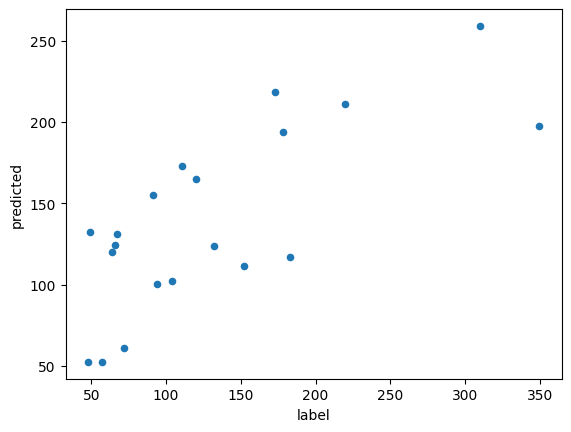

In [7]:
import matplotlib
pd.DataFrame(data={'label': y_i, 'predicted': y_hat_i}).plot.scatter(x='label', y='predicted')

In [8]:
# mean absolute percentage error

########### BEGIN COMPUTATION GRAPH ##########
## Everything below can be extracted from the abstract syntax tree

EPSILON=1e-1
abs_y_i = np.maximum(y_i, np.full_like(y_i, EPSILON))
ape = abs_y_i_minus_y_hat_i / abs_y_i
mape = np.mean(ape)
data_dict['abs_y_i'] = abs_y_i
data_dict['ape'] = ape
data_dict['mape'] = mape
print("mape is ", mape)

mean = ComputationNode('mean', None, 'mean', input_data=['ape'], output_data='mape')
ape_node = ComputationNode('ape', mean, 'vector_ratio', input_data=['abs_y_i_node', 'abs_y_i_minus_y_hat_i'], output_data='ape')

abs_y_i_minus_y_hat_i_node = ComputationNode('abs_y_i_minus_y_hat_i', ape_node, 'vector_abs', input_data=['y_i_minus_y_hat_i'], output_data='abs_y_i_minus_y_hat_i')
vector_difference_residuals = ComputationNode('vector_difference_residuals', abs_y_i_minus_y_hat_i_node, 'vector_diff', input_data=['y_i', 'y_hat_i'], output_data='y_i_minus_y_hat_i')
y_i_res_node = ComputationNode('literal_yi_res', vector_difference_residuals, 'vector', output_data='y_i')
y_hat_node = ComputationNode('literal_yhat', vector_difference_residuals, 'vector', output_data='y_hat_i')

abs_y_i_node = ComputationNode('abs_y_i', ape_node, 'vector_abs', input_data=['y_i'], output_data='abs_y_i')
y_i_den_node = ComputationNode('literal_yi_den', abs_y_i_node, 'vector', output_data='y_i')

parser = ComputationTreeParser(mean)
parser.visualizeDFG()
vis_containers = parser.visualization_containers
########### END COMPUTATION GRAPH ##########

r = AltairRenderer(vis_containers, data_dict, input_vars=input_vars)
charts = r.convert_to_charts()

charts.display()


mape is  0.40722344611432043


C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.HConcatChart(...)

## Additional Calculations and Figures

In the following cells, we run various calculations for the figures and examples in the paper.  In the next cell, we calculate the r2 value for the toy dataset used in the r2 motivating example.

In [9]:
# calculate r2 for the figure
coords = [(233.0, 197.0),
          (91.0, 155.0),
          (111.0, 172.0),
          (152.0, 111.0)]

df = pd.DataFrame(data=coords, columns=['y_hat_i', 'y_i'])
y_bar = df.y_i.mean()
r2 = 1 - ((np.sum(np.square(df.y_i - df.y_hat_i))) / (np.sum(np.square(df.y_i - y_bar))))
r2

-1.744644332845973

Next, we generate the figures for figure 5 by generating visualizations for different subgraphs within the r2 calculation.

In [10]:
def vis_from_node(n, data_dict, input_vars):    
    parser = ComputationTreeParser(n)
    parser.visualizeDFG()
    vis_containers = parser.visualization_containers
    ########### END COMPUTATION GRAPH ##########

    r = AltairRenderer(vis_containers, data_dict, input_vars=input_vars)
    charts = r.convert_to_charts()

    charts.display()

vis_from_node(mean_y, data_dict, input_vars)

C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

In [11]:
vis_from_node(vector_difference_variances, data_dict, input_vars)

C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.HConcatChart(...)

In [12]:
vis_from_node(square_variances, data_dict, input_vars)

C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\vegalite\v5\api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
C:\Users\dylan\anaconda3\envs\specmetric\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.HConcatChart(...)